In [41]:
from bsf_env import init_spark, init_mariadb_engine,set_spark_verbosity
from bsf_dbutilities import DBUtils
from pyspark.sql import functions as F
import pandas as pd

try:
    spark.stop()
except NameError:
    # SparkSession doesn't exist
    pass

spark = init_spark("bsf_utilities", log_level="WARN", show_progress=False, enable_ui=True,process_option='manual')
engine = init_mariadb_engine()
ingest_ts = spark.sql("SELECT current_timestamp()").collect()[0][0]

[Spark] Started 'bsf_utilities' log_level=WARN (effective=WARN), progress=False


25/10/04 09:49:09 WARN SQLConf: The SQL config 'spark.sql.adaptive.shuffle.targetPostShuffleInputSize' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.adaptive.advisoryPartitionSizeInBytes' instead of it.
25/10/04 09:49:09 WARN SQLConf: The SQL config 'spark.sql.adaptive.shuffle.targetPostShuffleInputSize' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.adaptive.advisoryPartitionSizeInBytes' instead of it.
25/10/04 09:49:09 WARN SQLConf: The SQL config 'spark.sql.adaptive.shuffle.targetPostShuffleInputSize' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.adaptive.advisoryPartitionSizeInBytes' instead of it.


In [ ]:
# ─── Setup Database Communications ──────────────────────────────────────
db = DBUtils(spark, ingest_ts)
db.spark_stats()

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 200)         # Expand width to avoid line breaks


from delta.tables import DeltaTable
import datetime, os
from pyspark.sql import functions as F

# List all databases
databases = [db.name for db in spark.catalog.listDatabases()]

for database in databases:
    print(f"\n=== Database: {database} ===\n")
    
    # Get all tables in this database
    tables = spark.catalog.listTables(database)
    if not tables:
        print("No tables found.")
        continue

    table_info = []
    
    for t in tables:
        full_table_name = f"{database}.{t.name}"
        row_count = spark.table(full_table_name).count()
        table_type = t.tableType
    
        # Default: no max date
        from pyspark.sql import functions as F
        import datetime
        import os
        
        max_date = None
        try:
            df_table = spark.table(full_table_name)
            
            if "LastLoadedDate" in df_table.columns:
                max_date = df_table.agg(F.max("LastLoadedDate")).collect()[0][0]
                field = "LastLoadedDate"
            elif "StockDate" in df_table.columns:
                max_date = df_table.agg(F.max("StockDate")).collect()[0][0]
                field = "StockDate"
            elif "ChangeDate" in df_table.columns:
                max_date = df_table.agg(F.max("ChangeDate")).collect()[0][0]
                field = "ChangeDate"
            else:
                try:
                    dt = DeltaTable.forName(spark, full_table_name)
                    history = dt.history(1)
                    max_date = history.select(F.max("timestamp")).collect()[0][0]
                    field = "timestamp"
                except:
                    max_date = None
        
            # --- Normalize to datetime ---
            if isinstance(max_date, datetime.date) and not isinstance(max_date, datetime.datetime):
                max_date = datetime.datetime.combine(max_date, datetime.time.min)
        
        except:
            # Non-Delta fallback
            table_location = (
                spark.sql(f"DESCRIBE FORMATTED {full_table_name}")
                     .filter("col_name='Location'")
                     .select("data_type")
                     .collect()[0][0]
            )
            max_date = datetime.datetime.fromtimestamp(os.path.getmtime(table_location))


    
        table_info.append((t.name, row_count, field, max_date, table_type))
    
    df_table_info = spark.createDataFrame(
        table_info,
        schema=["TableName", "RowCount","DateField", "MaxDate", "TableType"]
    )
    
    df_table_info.show(truncate=False)
    # 🚨 Safety stop — prevents accidental full execution
    raise RuntimeError("⚠️ This notebook is blocked. Do NOT run all cells without checking!")

In [ ]:
spark.stop()

In [ ]:
sdf = spark.table("bsf.company")
sdf.toPandas().describe()


In [ ]:
from copy import deepcopy
from bsf_config import CONFIG

In [ ]:
def load_settings(profile: str = "default" ):
    """Load settings, merging defaults with optional profile overrides.
       For `timeframe_map`, profile overrides REPLACE the whole dict
       instead of merging.
    """
    default_settings = deepcopy(CONFIG["default"])
    settings = deepcopy(default_settings)

    if profile and profile in CONFIG:
        overrides = CONFIG[profile]

        def merge(base, update, path=""):
            for k, v in update.items():
                current_path = f"{path}.{k}" if path else k

                # Special case: timeframe_map is replace, not merge
                if k == "timeframe_map":
                    old_value = base.get(k, "<not in default>")
                    #print(f"Override: {current_path}: default={old_value}, profile={v}")
                    base[k] = deepcopy(v)
                    continue

                if isinstance(v, dict) and k in base and isinstance(base[k], dict):
                    merge(base[k], v, current_path)
                else:
                    old_value = base.get(k, "<not in default>")
                    #print(f"Override: {current_path}: default={old_value}, profile={v}")
                    base[k] = deepcopy(v)

        merge(settings, overrides)

    return settings


In [ ]:
import json
mbsetting = load_settings()

config_json = json.dumps(mbsetting)
print(config_json)

In [ ]:
import json
mbsetting = load_settings("tier1")

config_json = json.dumps(mbsetting)
print(config_json)

In [86]:
wm_df = spark.sql(f"""
    SELECT *
    FROM bsf.companystockhistory_watermark
""").toPandas()
wm_dict = dict(zip(wm_df.CompanyId, wm_df.LastLoadedDate))
print(wm_df)

   CompanyId LastLoadedDate
0         52     2025-10-03


In [62]:
from pyspark.sql import functions as F

# Assuming your stock history table is a Delta table
df = spark.table("bsf.companystockhistory_watermark")

# Count rows per company per stock date
df.groupBy("CompanyId", "StockDate") \
  .agg(F.count("*").alias("row_count")) \
  .filter("row_count > 1") \
  .orderBy("CompanyId", "StockDate") \
  .show(50, truncate=False)


+---------+---------+---------+
|CompanyId|StockDate|row_count|
+---------+---------+---------+
+---------+---------+---------+



#############################################

In [74]:
df = spark.table("bsf.companystockhistory_watermark")
print(df.count())
df.show()

1
+---------+--------------+
|CompanyId|LastLoadedDate|
+---------+--------------+
|       52|    2025-10-03|
+---------+--------------+



In [87]:
spark.table("bsf.companystockhistory") \
     .orderBy(F.col("StockDate").desc()) \
     .show(10, truncate=False)

+---------+----------+-------+-------+-------+-------+--------+
|CompanyId|StockDate |Open   |High   |Low    |Close  |Volume  |
+---------+----------+-------+-------+-------+-------+--------+
|52       |2025-10-03|0.04549|0.04549|0.041  |0.041  |108000.0|
|52       |2025-10-02|0.044  |0.044  |0.044  |0.044  |0.0     |
|52       |2025-10-01|0.04005|0.044  |0.04005|0.044  |50000.0 |
|52       |2025-09-30|0.044  |0.044  |0.044  |0.044  |9900.0  |
|52       |2025-09-29|0.0441 |0.0441 |0.037  |0.04349|156505.0|
|52       |2025-09-26|0.054  |0.054  |0.054  |0.054  |0.0     |
|52       |2025-09-25|0.054  |0.054  |0.054  |0.054  |0.0     |
|52       |2025-09-24|0.0449 |0.054  |0.0449 |0.054  |10066.0 |
|52       |2025-09-23|0.035  |0.035  |0.035  |0.035  |0.0     |
|52       |2025-09-22|0.051  |0.055  |0.035  |0.035  |271066.0|
+---------+----------+-------+-------+-------+-------+--------+
only showing top 10 rows



In [ ]:
spark.table("bsf.companystockhistory") \
     .orderBy(F.col("StockDate").desc()) \
     .show(10, truncate=False)

In [88]:
df = spark.table("bsf.companyfundamental")
print(df.count())
df.show()

21
+---------+---------------+-------+--------+--------+--------------+--------------+------------------+-----------------+------------+----------------+-------------+-------------+--------+---------------+
|CompanyId|FundamentalDate|PeRatio|PegRatio| PbRatio|ReturnOnEquity|GrossMarginTTM|NetProfitMarginTTM|TotalDebtToEquity|CurrentRatio|InterestCoverage|EpsChangeYear|RevChangeYear|    Beta|ShortIntToFloat|
+---------+---------------+-------+--------+--------+--------------+--------------+------------------+-----------------+------------+----------------+-------------+-------------+--------+---------------+
|       52|     2024-12-29| -630.0|     0.0|-684.211|           0.0|           0.0|               0.0|              0.0|         0.4|             0.0|          0.0|          0.0|-3.76912|            0.0|
|       52|     2025-01-05| -800.0|     0.0|-684.211|           0.0|           0.0|               0.0|              0.0|         0.4|             0.0|          0.0|          0.0|-3.

In [71]:
df = spark.table("bsf.companyfundamental")
print(df.count())
df.show()

21
+---------+---------------+-------+--------+--------+--------------+--------------+------------------+-----------------+------------+----------------+-------------+-------------+--------+---------------+
|CompanyId|FundamentalDate|PeRatio|PegRatio| PbRatio|ReturnOnEquity|GrossMarginTTM|NetProfitMarginTTM|TotalDebtToEquity|CurrentRatio|InterestCoverage|EpsChangeYear|RevChangeYear|    Beta|ShortIntToFloat|
+---------+---------------+-------+--------+--------+--------------+--------------+------------------+-----------------+------------+----------------+-------------+-------------+--------+---------------+
|       52|     2024-11-24| -760.0|     0.0|-684.211|           0.0|           0.0|               0.0|              0.0|         0.4|             0.0|          0.0|          0.0|-3.75422|            0.0|
|       52|     2024-12-01| -530.0|     0.0|-684.211|           0.0|           0.0|               0.0|              0.0|         0.4|             0.0|          0.0|          0.0|-3.

In [84]:
from delta.tables import DeltaTable
from pyspark.sql import functions as F

# Reference the table
table_name = "bsf.companystockhistory_watermark"
dt = DeltaTable.forName(spark, table_name)

# Update CompanyId = 52 to new date
dt.update(
    condition = F.col("CompanyId") == 52,
    set = { "LastLoadedDate": F.lit("2025-10-01") }
)


In [99]:
df = spark.table("bsf.history_signals")
print(df.count())
# Show column names line by line
for c in df.columns:
    print(c)


25/10/04 16:13:47 WARN DeltaLog: Change in the table id detected while updating snapshot. 
Previous snapshot = Snapshot(path=file:/srv/lakehouse/tables/bsf.db/history_signals/_delta_log, version=0, metadata=Metadata(deb06f1f-358a-42a2-af29-6f523677c144,null,null,Format(parquet,Map()),{"type":"struct","fields":[{"name":"UserId","type":"integer","nullable":true,"metadata":{}},{"name":"CompanyId","type":"integer","nullable":true,"metadata":{}},{"name":"StockDate","type":"date","nullable":true,"metadata":{}},{"name":"Open","type":"double","nullable":true,"metadata":{}},{"name":"High","type":"double","nullable":true,"metadata":{}},{"name":"Low","type":"double","nullable":true,"metadata":{}},{"name":"Close","type":"double","nullable":true,"metadata":{}},{"name":"Return","type":"double","nullable":true,"metadata":{}},{"name":"MA","type":"double","nullable":true,"metadata":{}},{"name":"MA_slope","type":"double","nullable":true,"metadata":{}},{"name":"UpTrend_MA","type":"boolean","nullable":tru

289
CompanyId
StockDate
Open
High
Low
Close
Volume
O_roll1
O_roll2
O_roll3
O_roll4
C_roll1
C_roll2
C_roll3
C_roll4
H_roll1
H_roll2
H_roll3
H_roll4
L_roll1
L_roll2
L_roll3
L_roll4
Bull1
Bull2
Bull3
Bull4
Bear1
Bear2
Bear3
Bear4
Body1
Body2
Body3
Body4
Body
UpShadow
DownShadow
Range
Doji
Hammer
InvertedHammer
BullishMarubozu
BearishMarubozu
SpinningTop
BullishEngulfing
BearishEngulfing
BullishHarami
BearishHarami
ThreeWhiteSoldiers
ThreeBlackCrows
GapUp
GapDown
ClimacticCandle
NearHigh
NearLow
PatternCount
PatternScoreNorm
SignalStrength
BullishPctRaw
BearishPctRaw
BullishPctDirectional
BearishPctDirectional
MA
MA_slope
UpTrend_MA
DownTrend_MA
RecentReturn
UpTrend_Return
DownTrend_Return
ReturnPct
Volatility
LowVolatility
HighVolatility
ROC
MomentumUp
MomentumDown
ConfirmedUpTrend
ConfirmedDownTrend
Return
MomentumZ
FundamentalScore
FundamentalBad
peratio_norm
pbratio_norm
pegratio_norm
returnonequity_norm
grossmarginttm_norm
netprofitmarginttm_norm
totaldebttoequity_norm
currentratio_no

In [ ]:
from pyspark.sql import functions as F

sdf = spark.table("bsf.companystockhistory_watermark")

# Count rows per timeframe
sdf.groupBy("CompanyId") \
   .agg(F.max("LastLoadedDate").alias("max_date")) \
   .orderBy("CompanyId") \
   .show(truncate=False)

        watermark_update_df = sdf.groupBy("CompanyId") \
                               .agg(F.max("StockDate").alias("LastLoadedDate"))

In [ ]:
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, "bsf.history_signals")
dt.vacuum(retentionHours=0)  # ⚠ deletes unreferenced files immediately


In [ ]:
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, "bsf.history_signals")
dt.history().show(truncate=False)



In [ ]:
spark.read.format("delta").load("/srv/lakehouse/tables/bsf.db/history_signals") \
     .select("TimeFrame").distinct().show()



In [ ]:
count = spark.sql(f"""
    SELECT COUNT(DISTINCT CompanyId) as cnt
    FROM bsf.company
    WHERE ListingExchange IN (1,2,3,16)
      AND Active = 1
      AND LastClose < 0.1
      AND LastHistoryDate >= date_sub(current_date(), 30)
""").collect()[0]["cnt"]

print(count)




In [ ]:
sdf = spark.table("bsf.companystockhistory")
sdf.toPandas().describe()

In [ ]:
sdf = spark.table("bsf.companystockhistory")
counts_df = (
    sdf.groupBy("CompanyId")
      .agg(F.count("*").alias("row_count"))
      .orderBy("CompanyId")
)

counts_df.show(50, truncate=False)
#pdf.head(10).T

In [ ]:
sdf = spark.table("bsf.companystockhistory_watermark")
pdf = sdf.limit(10).toPandas()
#pdf.head(10).T

In [ ]:
sdf = spark.table("bsf.history_signals_last")
pdf = sdf.limit(10).toPandas()
pdf

In [ ]:
sdf = spark.table("bsf.signaldriver")
sdf.toPandas().describe()



In [ ]:
sdf = spark.table("bsf.history_signals")
pdf = sdf.limit(10).toPandas()
pdf

In [ ]:
sdf = spark.table("bsf.final_candidates")
pdf = sdf.limit(10).toPandas()
pdf

In [ ]:
sdf = spark.table("bsf.company")
# Group by CompanyId, TimeFrame, StockDate
counts_df = (
    sdf.groupBy("ListingExchange")
      .agg(F.count("*").alias("row_count"))
      .orderBy("ListingExchange")
)

counts_df.show(50, truncate=False)



sdf = spark.table("bsf.history_signals")

# Group by CompanyId, TimeFrame, StockDate
counts_df = (
    sdf.groupBy( "TimeFrame")
      .agg(F.count("*").alias("row_count"))
      .orderBy( "TimeFrame")
)

counts_df.show(50, truncate=False)


In [ ]:
# Assume you have a Spark DataFrame
sdf = spark.table("bsf.companystockhistory")

# 1️⃣ Show the schema (data types included)
sdf.printSchema()

# 2️⃣ Get a list of column names
# print(sdf.columns)

# 3️⃣ Show first few rows with all columns (default shows truncated view)
sdf.show(truncate=False)  

# 4️⃣ For more detailed metadata about columns
sdf.dtypes  # Returns a list of (column_name, data_type)


In [ ]:
# 🚨 Safety stop — prevents accidental full execution
raise RuntimeError("⚠️ This notebook is blocked. Do NOT run all cells without checking!")


In [101]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lightgbm import early_stopping

# ------------------------------
# 1️⃣ Load your Spark table into Pandas
# ------------------------------
df = spark.table("bsf.history_signals").toPandas()

# ------------------------------
# 2️⃣ Define features and target
# ------------------------------
# For testing, let's create a target using momentum as a placeholder:
# Buy = 1, Sell = -1, Hold = 0
df['Target'] = 0
df.loc[df['MomentumUp'] > 0.01, 'Target'] = 1
df.loc[df['MomentumDown'] > 0.01, 'Target'] = -1

# Drop non-feature columns
non_features = [
    'CompanyId', 'StockDate', 'BatchId', 'IngestedAt',
    'TimeFrame', 'Profile', 'UserId', 'Target'
]
feature_cols = [c for c in df.columns if c not in non_features]

X = df[feature_cols]
y = df['Target']

# ------------------------------
# 3️⃣ Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 4️⃣ Train LightGBM classifier
# ------------------------------
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train', 'eval'],
    num_boost_round=100,
    callbacks=[early_stopping(stopping_rounds=10)]
)

# ------------------------------
# 5️⃣ Evaluate
# ------------------------------
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1) - 1  # convert 0,1,2 -> -1,0,1

print(classification_report(y_test, y_pred_labels, target_names=['Sell','Hold','Buy']))

# ------------------------------
# 6️⃣ Feature importance (optional)
# ------------------------------
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()


/home/jupyter/.venv/python3.9_bsf/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/tmp/ipykernel_1250946/2693470814.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Target'] = 0
[LightGBM] [Fatal] Label must be in [0, 3), but found -1 in label


LightGBMError: Label must be in [0, 3), but found -1 in label

In [105]:
import numpy as np

# Example: simple rules for buy/sell/hold
def create_target(df):
    conditions = [
        (df['BullCount'] > df['BearCount']) & (df['MomentumUp'] > df['MomentumDown']),
        (df['BearCount'] > df['BullCount']) & (df['MomentumDown'] > df['MomentumUp'])
    ]
    choices = ['Buy', 'Sell']
    df['PatternType'] = np.select(conditions, choices, default='Hold')
    return df




In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier

# ------------------------------
# 1️⃣ Load Data from Spark
# ------------------------------
df = spark.table("bsf.history_signals").toPandas()

df = create_target(df)

# -----------------------------
# 2️⃣ Define features and target
# ------------------------------
# Choose relevant columns for modeling
feature_cols = [
    "Open","High","Low","Close","Volume",
    "O_roll1","O_roll2","O_roll3","O_roll4",
    "C_roll1","C_roll2","C_roll3","C_roll4",
    "H_roll1","H_roll2","H_roll3","H_roll4",
    "L_roll1","L_roll2","L_roll3","L_roll4",
    "Bull1","Bull2","Bull3","Bull4",
    "Bear1","Bear2","Bear3","Bear4",
    "Body1","Body2","Body3","Body4",
    "Body","UpShadow","DownShadow","Range",
    "Doji","Hammer","InvertedHammer","BullishMarubozu","BearishMarubozu","SpinningTop",
    "BullishEngulfing","BearishEngulfing","BullishHarami","BearishHarami",
    "ThreeWhiteSoldiers","ThreeBlackCrows","GapUp","GapDown","ClimacticCandle","NearHigh","NearLow",
    "PatternCount","PatternScoreNorm","SignalStrength",
    "BullishPctRaw","BearishPctRaw","BullishPctDirectional","BearishPctDirectional",
    "MA","MA_slope","UpTrend_MA","DownTrend_MA","RecentReturn","UpTrend_Return","DownTrend_Return",
    "ReturnPct","Volatility","LowVolatility","HighVolatility","ROC","MomentumUp","MomentumDown",
    "ConfirmedUpTrend","ConfirmedDownTrend","Return","MomentumZ","FundamentalScore"
]

# Make sure all features exist
feature_cols = [c for c in feature_cols if c in df.columns]

# Define target
# Here I assume you have a column like 'PatternType' or 'BuySellHold'
# Replace with your actual target column
target_col = 'PatternType'
df = df.dropna(subset=feature_cols + [target_col])

# Encode target if it's categorical
le = LabelEncoder()
y = le.fit_transform(df[target_col])
X = df[feature_cols]

# ------------------------------
# 3️⃣ Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 4️⃣ Train LightGBM
# ------------------------------
clf = LGBMClassifier(
    objective='multiclass',     # for multi-class classification
    num_class=len(le.classes_),
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=100,
    random_state=42
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    early_stopping_rounds=10,
    verbose=10
)

# ------------------------------
# 5️⃣ Evaluate
# ------------------------------
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

# ------------------------------
# 6️⃣ Predict new data (optional)
# ------------------------------
# X_new = df_new[feature_cols]
# y_new_pred = le.inverse_transform(clf.predict(X_new))


/home/jupyter/.venv/python3.9_bsf/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


KeyError: 'BullCount'

In [113]:
def create_target(df, bull_col='BullCount', bear_col='BearCount', ret_col='Return'):
    bullish_threshold = 2
    bearish_threshold = 2
    return_threshold = 0.005

    conditions = [
        (df[bull_col] >= bullish_threshold) & (df[ret_col] > return_threshold),
        (df[bear_col] >= bearish_threshold) & (df[ret_col] < -return_threshold)
    ]
    choices = ['Buy', 'Sell']
    df['Target'] = np.select(conditions, choices, default='Hold')
    return df



/home/jupyter/.venv/python3.9_bsf/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/tmp/ipykernel_1250946/4131484086.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Target'] = np.select(conditions, choices, default='Hold')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	train's multi_logloss: 4.24542e-05	eval's multi_logloss: 0.538216
Classification Report:
                   precision    recall  f1-score   support

BearishEngulfing       0.00      0.00      0.00         0
   BearishHarami       0.00      0.00      0.00         0
 BearishMarubozu       1.00      1.00      1.00         7
BullishEngulfing       0.00      0.00      0.00         0
   BullishHarami       1.00      1.00      1.00         1
 BullishMarubozu       1.00      1.00      1.00         4
            Doji       1.00      1.00      1.00        28
         GapDown       1.00      1.00      1.00         3
           GapUp       1.00      1.00      1.00         2
        NearHigh       1.00      1.00      1.00        11
     SpinningTop       1.00      1.00      1.00         1
 ThreeBlackCrows       0.00      0.00      0.00         1

       micro avg       0.98      0.98      0.98     

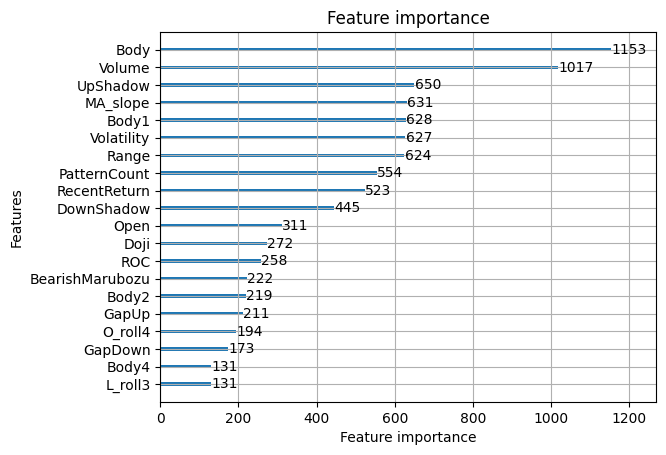

In [118]:
# ==============================
# 1️⃣ Load libraries and Spark table
# ==============================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load Spark table
df = spark.table("bsf.history_signals").toPandas()  # convert to pandas for LightGBM

# ==============================
# 2️⃣ Create target: Buy/Sell/Hold
# ==============================
df = create_target(df)  # make sure this adds 'PatternType' or your target column

# ==============================
# 3️⃣ Prepare features
# ==============================
exclude_cols = [
    'CompanyId', 'StockDate', 'BatchId', 'IngestedAt', 
    'TimeFrame', 'Profile', 'UserId', 'PatternType'  # exclude string target
]

# Ensure all features are numeric (int/float)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
features = [c for c in numeric_cols if c not in exclude_cols]

X = df[features]

# Encode target
y = df['PatternType'].fillna("None")  # fill missing patterns
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ==============================
# 4️⃣ Train/test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, shuffle=True
)

# ==============================
# 5️⃣ Prepare LightGBM datasets
# ==============================
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# ==============================
# 6️⃣ Train LightGBM
# ==============================
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),  # automatically detect number of classes
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train', 'eval'],
    num_boost_round=200,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)


from sklearn.metrics import classification_report, confusion_matrix

# ensure all classes are considered
all_labels = list(range(len(le.classes_)))

print("Classification Report:\n", classification_report(
    y_test, 
    y_pred, 
    labels=all_labels,           # use numeric labels
    target_names=le.classes_,    # map to string names
    zero_division=0              # avoid divide-by-zero warnings
))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=all_labels))


# ==============================
# 7️⃣ Evaluate
# ==============================
y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

# ensure all classes are considered
all_labels = list(range(len(le.classes_)))

print("Classification Report:\n", classification_report(
    y_test, 
    y_pred, 
    labels=all_labels,           # use numeric labels
    target_names=le.classes_,    # map to string names
    zero_division=0              # avoid divide-by-zero warnings
))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=all_labels))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ==============================
# 8️⃣ Optional: feature importance
# ==============================
lgb.plot_importance(model, max_num_features=20)
plt.show()

